In [1]:
import pickle
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# --- Load dataset ---
with open("laughter_dataset.pkl", "rb") as f:
    X, y, resumen_data = pickle.load(f)


# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

rf_ros = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_ros.fit(X_res, y_res)
y_pred_ros = rf_ros.predict(X_test)

print("\n🎯 Random Forest + Oversampling")
print(classification_report(y_test, y_pred_ros))
print("ROC AUC:", roc_auc_score(y_test, rf_ros.predict_proba(X_test)[:, 1]))



🎯 Random Forest + Oversampling
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     46424
           1       0.01      0.14      0.02       141

    accuracy                           0.96     46565
   macro avg       0.50      0.55      0.50     46565
weighted avg       0.99      0.96      0.97     46565

ROC AUC: 0.5490371359641565


⚠️ Warning: no positive samples in training set. Setting scale_pos_weight to 1.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🎯 XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46424
           1       0.00      0.00      0.00       141

    accuracy                           1.00     46565
   macro avg       0.50      0.50      0.50     46565
weighted avg       0.99      1.00      1.00     46565

[[46424     0]
 [  141     0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

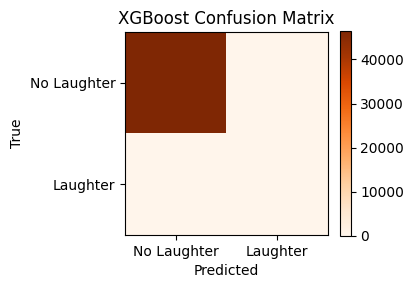

ROC AUC: 0.6057240813323508


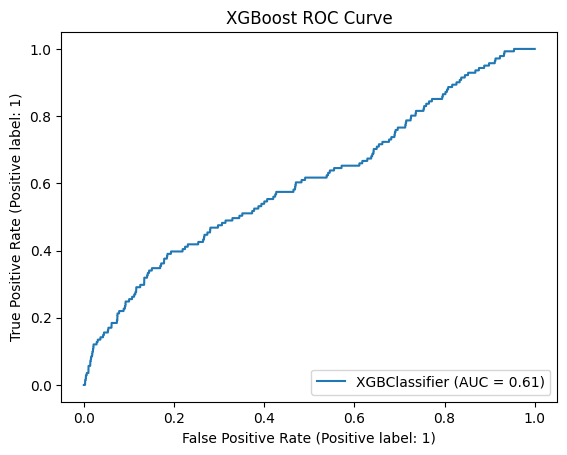

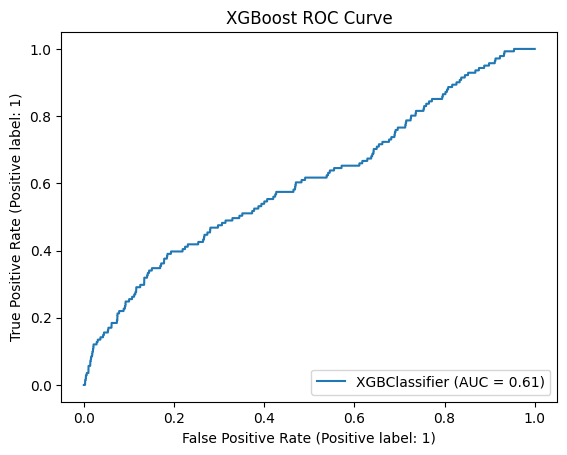

In [3]:
# --- XGBoost ---
n_pos = np.sum(y_train == 1)
if n_pos == 0:
    print("⚠️ Warning: no positive samples in training set. Setting scale_pos_weight to 1.")
    scale = 1.0
else:
    scale = np.sum(y_train == 0) / n_pos
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n🎯 XGBoost")
print(classification_report(y_test, y_pred_xgb))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)
plt.figure(figsize=(4, 3))
plt.imshow(cm_xgb, cmap='Oranges', interpolation='nearest')
plt.title("XGBoost Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["No Laughter", "Laughter"])
plt.yticks([0, 1], ["No Laughter", "Laughter"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
try:
    auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
    print("ROC AUC:", auc)
    RocCurveDisplay.from_estimator(xgb, X_test, y_test)
    plt.title("XGBoost ROC Curve")
    plt.show()
except ValueError as e:
    print(f"❌ ROC AUC could not be computed: {e}")
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("XGBoost ROC Curve")
plt.show()


In [8]:
X = np.array(X)
y = np.array(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(class_weight="balanced", random_state=fold)
    rf.fit(X_train, y_train)
    auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
    rf_scores.append(auc)
    print(f"📂 Fold {fold+1}: AUC = {auc:.3f}")

print("\n📊 Mean AUC (Stratified CV):", np.mean(rf_scores))


📂 Fold 1: AUC = 0.545
📂 Fold 2: AUC = 0.546
📂 Fold 3: AUC = 0.549
📂 Fold 4: AUC = 0.563
📂 Fold 5: AUC = 0.559

📊 Mean AUC (Stratified CV): 0.5523247444913887
